# Pokèmon type inferring

In this notebook, I'll try to infer the type of a Pokèmon based on its stat distribution.

# 1. Problem definition

> Find which two variables can define the type of a pokemon, if any.

**Types** are properties for Pokémon (*and also moves, but we're not interested in that*).  
A Pokèmon can have two types and at least one.

As of Generation VIII (the latest Pokèmon games), there are 18 types:

![pokemon-types](./img/pokemon-types.png)

With the current 18-type system, there are a total of 324 possible ways to assign types to Pokémon, with 171 unique combinations.  
As of Generation VIII, 154 different type combinations have been used.

All the above information was provided by [Bulbapedia](https://bulbapedia.bulbagarden.net/wiki/Type).

# 2. Data

I am going to use a dataset provided by [Kaggle](https://www.kaggle.com/alopez247/pokemon). It contains 721 entries of all the Pokèmon released up to Generation VI, so we're missing data about the latest two generations.  

A possible improvement would be to acquire data on Generation VII-VIII and use them as validation/test sets.

# 3. Evaluation

I will be evaluating the model based on its **accuracy** of predicting the correct type for a Pokèmon.  
I will be considering <font color="green"><b>valid</b></font> a prediction that correctely predicts <u>at least</u> one of the two types of a Pokèmon (if such Pokèmon has two types)

# 4. Features

1. **Number**. Pokémon ID in the Pokédex.
2. **Name**. Name of the Pokémon.
3. **Type_1**. Primary type.
4. **Type_2**. Second type, in case the Pokémon has it.
5. **Total**. Sum of all the base stats (Health Points, Attack, Defense, Special Attack, Special Defense, and Speed).
6. **HP**. Base Health Points.
7. **Attack**. Base Attack.
8. **Defense**. Base Defense.
9. **Sp_Atk**. Base Special Attack.
10. **Sp_Def**. Base Special Defense.
11. **Speed**. Base Speed.
12. **Generation**. Number of the generation when the Pokémon was introduced.
13. **isLegendary**. Boolean that indicates whether the Pokémon is Legendary or not.
14. **Color**. Color of the Pokémon according to the Pokédex.
15. **hasGender**. Boolean that indicates if the Pokémon can be classified as female or male.
16. **Pr_male**. In case the Pokémon has Gender, the probability of its being male. The probability of being female is, of course, 1 minus this value.
17. **EggGroup1**. Egg Group of the Pokémon.
18. **EggGroup2**. Second Egg Group of the Pokémon, in case it has two.
19. **hasMegaEvolution**. Boolean that indicates whether the Pokémon is able to Mega-evolve or not.
20. **Height_m**. Height of the Pokémon, in meters.
21. **Weight_kg**. Weight of the Pokémon, in kilograms.
22. **Catch_Rate**. Catch Rate.
23. **Body_Style**. Body Style of the Pokémon according to the Pokédex.

I will <font color="red"><b>not</b></font> take into consideration the feature **hasMegaEvolution** (*even though the dataset contains them*) because:
* some mega-evolutions change the original type of the Pokèmon (eg. Sceptile is `Grass` while Mega-Sceptile is `Grass-Dragon`)
* mega-evolution is a feature that is completely arbitrary (i.e. GameFreak decides which Pokèmon can megaevolve, without any rules)

Furthermore, I will <font color="red"><b>not</b></font> take into consideration the following features:
* **Number**: useless outside of Pokèdex order
* **Name**: doesn't imply the Pokèmon type
* **Generation**: just a chronological feature, nothing to do with Pokèmon type
* **Pr_male**: the probability of being either male or female doesn't affect their type
    - some examples of gender-exclusive Pokèmons: Vespiquen, Milotic, Kangaskhan

I will consequently `drop()` the respective columns.

# 5. Data exploration

In [1]:
import numpy as np
import seaborn as sb
import pandas as pd
from math import isnan
import matplotlib.pyplot as plt

seed = 13457812
def setseed(seed=seed):
    np.random.seed(seed)

In [2]:
df = pd.read_csv("./data/pokemon.csv")
df.head()

,Number,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,...,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,Green,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,Green,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,Green,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
3,4,Charmander,Fire,NaN,309,39,52,43,60,50,...,Red,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
4,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,...,Red,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Number            721 non-null    int64  
 1   Name              721 non-null    object 
 2   Type_1            721 non-null    object 
 3   Type_2            350 non-null    object 
 4   Total             721 non-null    int64  
 5   HP                721 non-null    int64  
 6   Attack            721 non-null    int64  
 7   Defense           721 non-null    int64  
 8   Sp_Atk            721 non-null    int64  
 9   Sp_Def            721 non-null    int64  
 10  Speed             721 non-null    int64  
 11  Generation        721 non-null    int64  
 12  isLegendary       721 non-null    bool   
 13  Color             721 non-null    object 
 14  hasGender         721 non-null    bool   
 15  Pr_Male           644 non-null    float64
 16  Egg_Group_1       721 non-null    object 
 1

In [4]:
df.Body_Style.value_counts()

bipedal_tailed      158
quadruped           135
bipedal_tailless    109
two_wings            63
head_arms            39
head_only            34
with_fins            31
insectoid            30
head_base            30
serpentine_body      29
four_wings           18
head_legs            17
multiple_bodies      15
several_limbs        13
Name: Body_Style, dtype: int64

Before proceeding, it would be convenient to have a single column that holds the type of the Pokèmon.

In [5]:
# Create a single column for Pokèmon type
_types = []

for i in range(len(df)):
    first_type = df.Type_1[i]
    second_type = df.Type_2[i]

    if type(second_type) != str:
        # value is NaN, add only the first type
        _types.append(tuple((first_type,)))
    else:
        _types.append((first_type, second_type))

_types[:5]

[('Grass', 'Poison'),
 ('Grass', 'Poison'),
 ('Grass', 'Poison'),
 ('Fire',),
 ('Fire',)]

Now, let's uniform the tuples. What I mean by that is that now there are types that are conceptually the same, even if they're stored differently.  
An example: `Rayquaza` is type `Dragon/Flying`, while `Noivern` is type `Flying/Dragon`.  
I want to have a single type that describes both, such as `(Dragon, Flying)`.


In [6]:
# noivern
df.iloc[713].Type_1, df.iloc[713].Type_2

('Flying', 'Dragon')

In [7]:
# rayquaza
df.iloc[383].Type_1, df.iloc[383].Type_2

('Dragon', 'Flying')

In [8]:
# Uniform the tuples
# i.e. turning ("Dragon", "Flying") and ("Flying", "Dragon") equal
uniques = []

for i, _type in enumerate(_types):
    if _type in uniques:
        pass
    else:
        try:
            inverted = (_type[1], _type[0])
            _types[i] = inverted

            if inverted not in uniques:
                uniques.append(inverted)
        except IndexError:  # tuple is 1-D
            if _type not in uniques:
                uniques.append(_type)

In [9]:
# Check if it worked
("Flying", "Dragon") in uniques, ("Dragon", "Flying") in uniques

(True, False)

This means that `uniques` contains the type `(Flying, Dragon)` but not `(Dragon, Flying)`.  
Did I succeed to change this behaviour in the `_types` array too?

In [10]:
("Flying", "Dragon") in _types, ("Dragon", "Flying") in _types

(True, False)

I did!  

Let's make these changes permanent.

In [11]:
df.insert(4, "Type", pd.Series(_types))
df.head()

,Number,Name,Type_1,Type_2,Type,Total,HP,Attack,Defense,Sp_Atk,...,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,1,Bulbasaur,Grass,Poison,"(Poison, Grass)",318,45,49,49,65,...,Green,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
1,2,Ivysaur,Grass,Poison,"(Poison, Grass)",405,60,62,63,80,...,Green,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
2,3,Venusaur,Grass,Poison,"(Poison, Grass)",525,80,82,83,100,...,Green,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
3,4,Charmander,Fire,NaN,"(Fire,)",309,39,52,43,60,...,Red,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
4,5,Charmeleon,Fire,NaN,"(Fire,)",405,58,64,58,80,...,Red,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed


### Base Stat Total (BST)

The BST of a Pokèmon is the sum of all its base stats (HP, Atk, Def, SpAtk, SpDef, Speed).  
It greatly influeces the "strength" of a Pokèmon in battle, its advantages and disadvantages in different situations.  

I want to plot the average BST for each Pokèmon type with a `boxplot`.  
I know by experience that generally some types excell in some stats rather than other, but I want to see if there are some types than tend to have higher BST.  
What I'll do is:
* create typed-groups of Pokèmon, i.e. 18 lists that contain BST values of each Pokèmon of that type
* iterate over `df` rows
* assign each Pokèmon BST to the respective group (two groups if it has two types)

In [12]:
# create groups dictionary
groups = {}

for t in set(df.Type_1):
    groups[t] = []

# sort dict alphabetically
groups = {k: v for k, v in sorted(groups.items(), key=lambda item: item[0])}
groups

{'Bug': [],
 'Dark': [],
 'Dragon': [],
 'Electric': [],
 'Fairy': [],
 'Fighting': [],
 'Fire': [],
 'Flying': [],
 'Ghost': [],
 'Grass': [],
 'Ground': [],
 'Ice': [],
 'Normal': [],
 'Poison': [],
 'Psychic': [],
 'Rock': [],
 'Steel': [],
 'Water': []}

In [13]:
from math import isnan

for i, row in df.iterrows():
    groups[row.Type_1].append(row.Total)

    if type(row.Type_2) != str and not isnan(row.Type_2):
        groups[row.Type_2].append(row.Total)

Now we have mapped each Pokèmon to (at least) a group, let's visualize the average BST of each group.  

I can think of two ways to visualize the data we gathered:
* `boxplot`
* `barplot` with confidence values

Let's see both

### Boxplots

In [14]:
# define a list of colors, for visualization purposes
colors = [
    '#97bc49',   # bug
    '#595464',   # dark
    '#266dbc',   # dragon
    '#efd058',   # electric
    '#e195e0',   # fairy
    '#c14e68',   # fighting
    '#f59e60',   # fire
    '#8fa7d7',   # flying
    '#5469a5',   # ghost
    '#73b565',   # grass
    '#cf7b50',   # ground
    '#82c9be',   # ice
    '#8f979e',   # normal
    '#a26fc1',   # poison
    '#ec7876',   # psychic
    '#c4b58e',   # rock
    '#618b9d',   # steel
    '#568ece',   # water
]
poor_contrast = ['#e195e0', '#f59e60', '#cf7b50', '#ec7876'] # fairy, fire, ground, psychic

def contrast_color(color):
    """
    Returns a good contrast color for the median line to be seen in the boxplot.
    """
    if color in poor_contrast:
        return '#000000'  # black
    else:
        return '#f48435'  # default

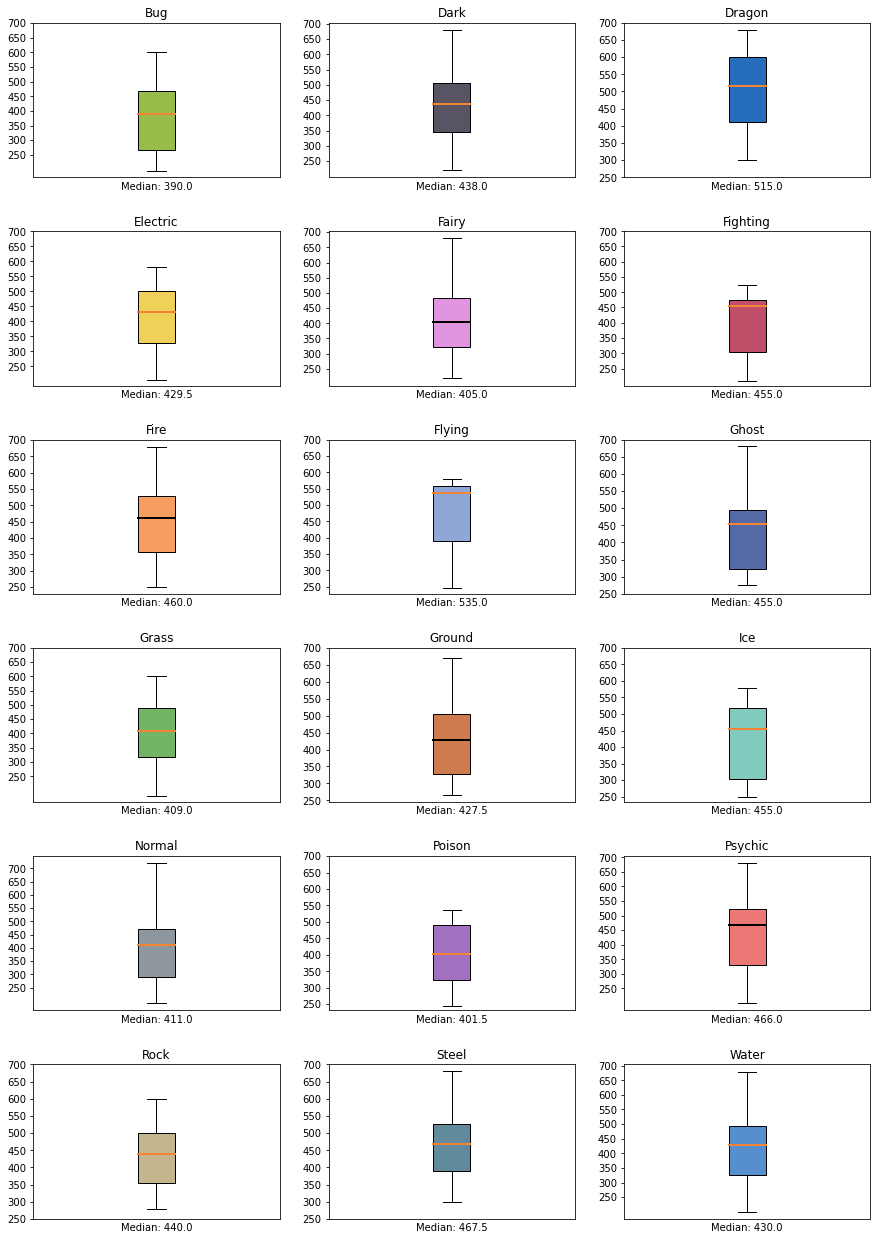

In [15]:
def boxplots():
    ncols = 3
    nrows = 6
    yticks = np.arange(250, 750, 50)  # common yticks for all the graphs
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,22))

    row = 0
    for i, (key, val) in enumerate(groups.items()):
        if i % ncols == 0 and i != 0:
            row += 1

        ax[row, i%ncols].boxplot(val,
            patch_artist=True,
            boxprops={'facecolor': colors[i]},
            medianprops={'linewidth': 2, 'color': contrast_color(colors[i])}
        )
        #ax[row, i%ncols].set_facecolor(colors[i])  # sets backgr color
        ax[row, i%ncols].set_title(key)
        ax[row, i%ncols].set_xticks([])
        ax[row, i%ncols].set_xlabel(f"Median: {np.median(val)}")
        ax[row, i%ncols].set_yticks(yticks)
        #print(f"Iter #{i} ({key}): row: {row}, col: {i%ncols}")  # debug

    # vertical margin between rows
    fig.subplots_adjust(hspace=0.35)

boxplots()

### Barplots with confidence values

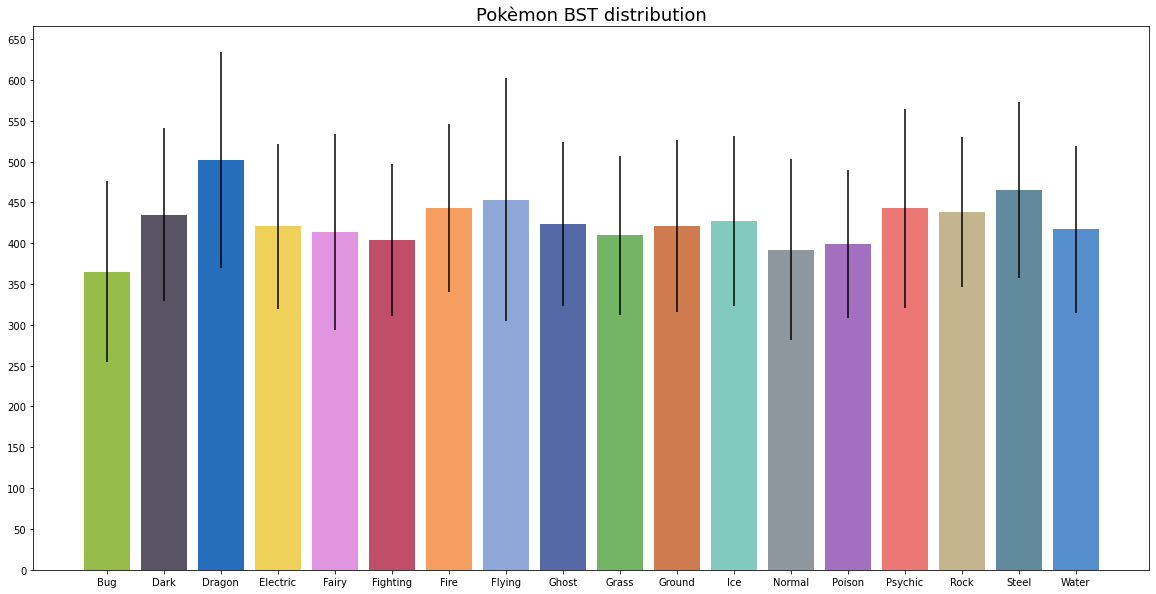

In [16]:
# calculate average BST and std for each type
stats = {}

for key, val in groups.items():
    stats[key] = {
        'mean': np.round(np.mean(val), 2),
        'std': np.round(np.std(val), 2)
    }

def barplots_with_confidence():
    yticks = np.arange(0, 700, 50)  # common yticks for all the graphs
    fig, ax = plt.subplots(figsize=(20,10))

    labels = [k for k in stats.keys()]
    means = [v['mean'] for v in stats.values()]
    stds = [v['std'] for v in stats.values()]

    ax.bar(labels, means, color=colors, yerr=stds, align='center')
    ax.set_title("Pokèmon BST distribution", fontsize=18)
    ax.set_yticks(yticks)

barplots_with_confidence()

### Weight and height

Typically, weight and height (even in our world) tend to have a similar growth, that is they are in a **positive correlation**.  
Let's see if this assumption is also valid among Pokèmon.

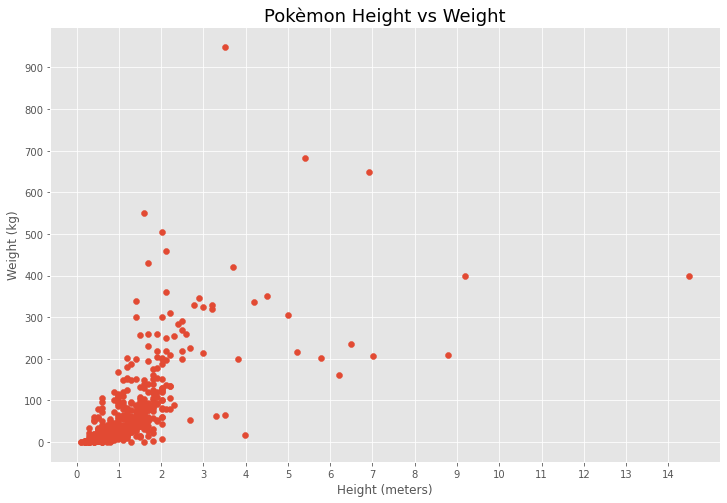

In [17]:
def scatter_weight_height():
    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(figsize=(12,8))

        ax.scatter(df.Height_m, df.Weight_kg)

        ax.set_xticks(np.arange(0, 15, 1))
        ax.set_yticks(np.arange(0, 1000, 100))
        ax.set_xlabel("Height (meters)")
        ax.set_ylabel("Weight (kg)")
        ax.set_title("Pokèmon Height vs Weight", fontsize=18)
    plt.show()

scatter_weight_height()

In [18]:
np.corrcoef(df.Height_m, df.Weight_kg)[0,1]

0.6613415027894425

Mostly what I expected. There is a positive correlation albeit some outliers.  

**PS**: Are you curious about what is [the heaviest (but not tallest)](https://bulbapedia.bulbagarden.net/wiki/Groudon_(Pok%C3%A9mon)) and [the tallest (but not heaviest)](https://bulbapedia.bulbagarden.net/wiki/Wailord_(Pok%C3%A9mon)) Pokèmons?

## Correlation matrix

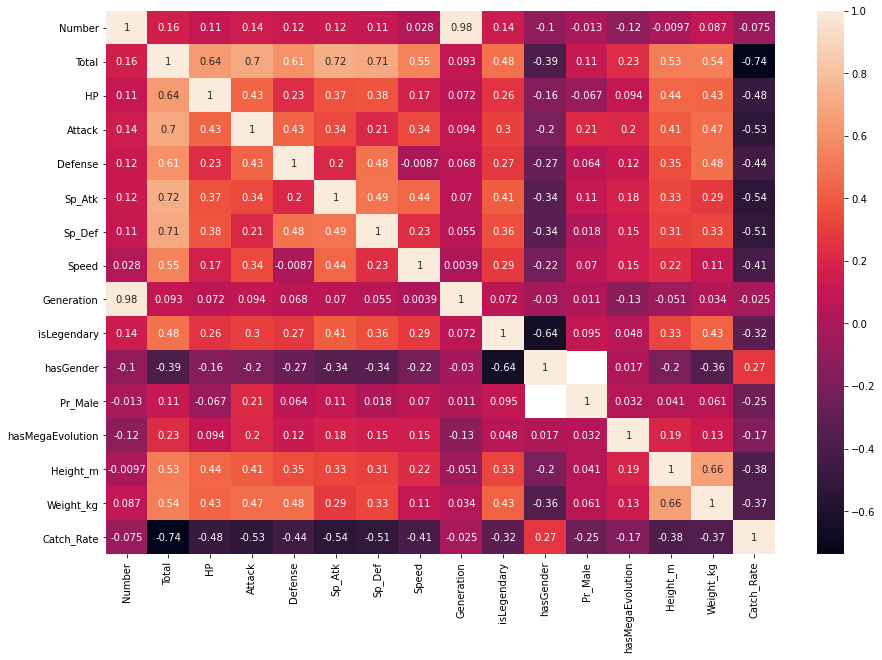

In [19]:
 def corr_matrix():
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(15,10))

    ax = sb.heatmap(corr,
        annot=True,
        cbar=True
    )

corr_matrix()

There are some interesting correlations, I will give my interpretation on some of them

* `Total` vs `Catch_Rate`: generally, when the BST is high it means that the Pokèmon is likely a legendary or a mithical Pokèmon, which means they are unique and rare Pokèmons. That makes them generally hard to catch
* `Total` and `isLegendary`: for the same reason as above
* `hasGender` and `isLegendary`: all legendary Pokèmon have no gender, otherwise it would be possible to [breed](https://bulbapedia.bulbagarden.net/wiki/Pok%C3%A9mon_breeding) them. The correlation would be `-1` if all genderless Pokèmon were legendary, but some aren't (eg Magnemite, Staryu, Porygon...)

## Filling missing values

In [20]:
df.isna().sum()

Number                0
Name                  0
Type_1                0
Type_2              371
Type                  0
Total                 0
HP                    0
Attack                0
Defense               0
Sp_Atk                0
Sp_Def                0
Speed                 0
Generation            0
isLegendary           0
Color                 0
hasGender             0
Pr_Male              77
Egg_Group_1           0
Egg_Group_2         530
hasMegaEvolution      0
Height_m              0
Weight_kg             0
Catch_Rate            0
Body_Style            0
dtype: int64

There are two different approaches:
* `Pr_Male` is `NaN` when referencing Legendary and Special Pokèmon (like Rayquaza, Kyogre, Mew ecc.) since they have no gender. I will `fillna()` with `0.0`
* `Egg_Group_2` can be null, therefore I will fill these with `"null"`
    - same treatment for `Type_2`, even if by now it's irrelevant

In [21]:
df.Pr_Male.fillna(0.0, inplace=True)
df.Type_2.fillna('null', inplace=True)
df.Egg_Group_2.fillna('null', inplace=True)

# Check Rayquaza for testing
df[df.Name == "Rayquaza"].T

,383
Number,384
Name,Rayquaza
Type_1,Dragon
Type_2,Flying
Type,"(Flying, Dragon)"
Total,680
HP,105
Attack,150
Defense,90
Sp_Atk,150


In [22]:
df.isna().sum()

Number              0
Name                0
Type_1              0
Type_2              0
Type                0
Total               0
HP                  0
Attack              0
Defense             0
Sp_Atk              0
Sp_Def              0
Speed               0
Generation          0
isLegendary         0
Color               0
hasGender           0
Pr_Male             0
Egg_Group_1         0
Egg_Group_2         0
hasMegaEvolution    0
Height_m            0
Weight_kg           0
Catch_Rate          0
Body_Style          0
dtype: int64

## Feature encoding

Now we need to turn all the categorical features into numerical features.  
What are the ones we are interested in?  

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Number            721 non-null    int64  
 1   Name              721 non-null    object 
 2   Type_1            721 non-null    object 
 3   Type_2            721 non-null    object 
 4   Type              721 non-null    object 
 5   Total             721 non-null    int64  
 6   HP                721 non-null    int64  
 7   Attack            721 non-null    int64  
 8   Defense           721 non-null    int64  
 9   Sp_Atk            721 non-null    int64  
 10  Sp_Def            721 non-null    int64  
 11  Speed             721 non-null    int64  
 12  Generation        721 non-null    int64  
 13  isLegendary       721 non-null    bool   
 14  Color             721 non-null    object 
 15  hasGender         721 non-null    bool   
 16  Pr_Male           721 non-null    float64
 1

The categorical features that have to be converted are: `Color`, `Egg_Group_1`, `Egg_Group_2` and `Body_Style`.  
There is also `Type`, which is a label.

I will use `OneHotEncoder` to encode the features and `MultiLabelBinarizer` to encode the label.  

But first, we have to create X and y.

In [24]:
X = df.drop(["Type", "Type_1", "Type_2", "Number", "Name", "Pr_Male", "Generation", "hasMegaEvolution"],
            axis=1)
y = df["Type"]

# Backup copies
X_tmp = X.copy()
y_tmp = y.copy()

In [25]:
from sklearn.preprocessing import OrdinalEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer

# features encoding (X)
str_features = ["Color", "Egg_Group_1", "Egg_Group_2", "Body_Style"]
feat_trans = ColumnTransformer([("ordinal", OrdinalEncoder(), str_features)], remainder="passthrough")
transformed_X = feat_trans.fit_transform(X)

# target encoding (y)
tup_features = ["Type"]
mlab = MultiLabelBinarizer()
transformed_y = mlab.fit_transform(y)

In [26]:
# feature encoding removes column names from X
# we have to reconstruct them manually
remaining_columns = [c for c in list(X.columns) if c not in str_features]
X_trans = pd.DataFrame(transformed_X,
                    columns=str_features+remaining_columns)  # first columns will be the encoded ones
y_trans = pd.DataFrame(transformed_y)

In [27]:
X_trans.head()

,Color,Egg_Group_1,Egg_Group_2,Body_Style,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,isLegendary,hasGender,Height_m,Weight_kg,Catch_Rate
0,3,10,6,9,318,45,49,49,65,65,45,False,True,0.71,6.9,45
1,3,10,6,9,405,60,62,63,80,80,60,False,True,0.99,13,45
2,3,10,6,9,525,80,82,83,100,100,80,False,True,2.01,100,45
3,7,10,2,0,309,39,52,43,60,50,65,False,True,0.61,8.5,45
4,7,10,2,0,405,58,64,58,80,65,80,False,True,1.09,19,45


In [28]:
y_trans.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Modeling with RandomForest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, random_state=seed, test_size=0.2)

rfc = RandomForestClassifier(random_state=seed)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.10344827586206896

In [30]:
# cross validate the above score
from sklearn.model_selection import cross_val_score

np.mean(cross_val_score(rfc, X_trans, y_trans, cv=5))

0.12337164750957856

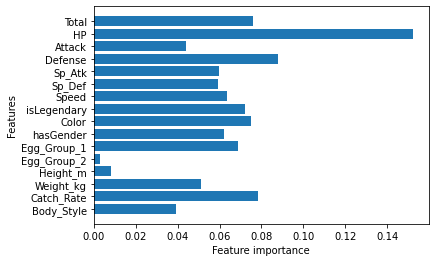

In [31]:
def plot_feat_importance(columns, feature_importances, n=20):
    # Plot the df
    fig, ax = plt.subplots()
    ax.barh(columns[:n], feature_importances[:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

plot_feat_importance(X.columns, rfc.feature_importances_)

*It seems there are some "useless" features, but we'll examine them later if needed.*

Well... not satisfying at all.  
This is to be expected, though: as we said, there is no logical way a Pokèmon's type is given.  
Let's see if we can auto-tune some parameters using `RandomizedSearchCV`.

In [32]:
from sklearn.model_selection import RandomizedSearchCV

grid = {
    "n_estimators": [100,200,500,1000,1200],
    "max_depth": [None,5,10,20,30],
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2,4,6],
    "min_samples_leaf": [1,2,4]
}

clf = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=grid,
    n_iter=25,
    cv=5,
    random_state=seed,
)
clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [32]:
clf.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None}

In [33]:
clf.score(X_test, y_test)

0.10344827586206896

Let's now try `GridSearchCV`

In [34]:
grid2 = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [6],
    'min_samples_leaf': [1, 2]
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=grid2,
    cv=5,
    random_state=seed,
)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2], 'min_samples_split': [6],
                         'n_estimators': [100, 200, 500]})

In [35]:
clf.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 100}

In [36]:
clf.score(X_test, y_test)

0.10344827586206896

## Modeling with KNeighborsClassifier

In [50]:
from sklearn.neighbors import KNeighborsClassifier

best_score = 0
knn = None
for n in np.arange(5,15,2):
    _knn = KNeighborsClassifier(n_neighbors=n)
    
    _knn.fit(X_train, y_train)
    score = _knn.score(X_test, y_test)
    
    print(f"N: {n}, score: {score}")
    
    if score > best_score:
        best_score = score
        knn = _knn

N: 5, score: 0.04827586206896552
N: 7, score: 0.027586206896551724
N: 9, score: 0.013793103448275862
N: 11, score: 0.006896551724137931
N: 13, score: 0.006896551724137931


In [57]:
grid = {
    "leaf_size": np.arange(1,50,2),
    "n_neighbors": np.arange(1,30,2),
    "p": [1,2]
}

clf = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=grid,
    n_iter=30,
    cv=5,
    random_state=seed,
)
clf.fit(X_train, y_train);

In [58]:
clf.best_params_

{'p': 1, 'n_neighbors': 3, 'leaf_size': 9}

In [59]:
clf.score(X_test, y_test)

0.07586206896551724

No luck.  
Best we can try now is to reduce the number of features.  
Let's start anew.

## Second attempt: feature encoding

This time, we will `drop()` some more columns. As we have seen above, there are some really ininfluent features.

In [37]:
X_tmp.head()

,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,isLegendary,Color,hasGender,Egg_Group_1,Egg_Group_2,Height_m,Weight_kg,Catch_Rate,Body_Style
0,318,45,49,49,65,65,45,False,Green,True,Monster,Grass,0.71,6.9,45,quadruped
1,405,60,62,63,80,80,60,False,Green,True,Monster,Grass,0.99,13.0,45,quadruped
2,525,80,82,83,100,100,80,False,Green,True,Monster,Grass,2.01,100.0,45,quadruped
3,309,39,52,43,60,50,65,False,Red,True,Monster,Dragon,0.61,8.5,45,bipedal_tailed
4,405,58,64,58,80,65,80,False,Red,True,Monster,Dragon,1.09,19.0,45,bipedal_tailed


Let's further drop `["Egg_Group1", "Egg_Group2", "Height_m", "Weight_kg", "Body_Style"]`

In [38]:
X = X_tmp.drop(["Egg_Group_1", "Egg_Group_2", "Height_m", "Weight_kg", "Body_Style"], axis=1)
X.head()

,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,isLegendary,Color,hasGender,Catch_Rate
0,318,45,49,49,65,65,45,False,Green,True,45
1,405,60,62,63,80,80,60,False,Green,True,45
2,525,80,82,83,100,100,80,False,Green,True,45
3,309,39,52,43,60,50,65,False,Red,True,45
4,405,58,64,58,80,65,80,False,Red,True,45


In [39]:
# features encoding (X)
str_features = ["Color"]
feat_trans = ColumnTransformer([("ordinal", OrdinalEncoder(), str_features)], remainder="passthrough")
transformed_X = feat_trans.fit_transform(X)

# target encoding (y)
tup_features = ["Type"]
mlab = MultiLabelBinarizer()
transformed_y = mlab.fit_transform(y)

In [40]:
# feature encoding removes column names from X
# we have to reconstruct them manually
remaining_columns = [c for c in list(X.columns) if c not in str_features]
X_trans = pd.DataFrame(transformed_X,
                    columns=str_features+remaining_columns)  # first columns will be the encoded ones
y_trans = pd.DataFrame(transformed_y)

In [41]:
X_trans.head()

,Color,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,isLegendary,hasGender,Catch_Rate
0,3,318,45,49,49,65,65,45,False,True,45
1,3,405,60,62,63,80,80,60,False,True,45
2,3,525,80,82,83,100,100,80,False,True,45
3,7,309,39,52,43,60,50,65,False,True,45
4,7,405,58,64,58,80,65,80,False,True,45


In [42]:
y_trans.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, random_state=seed, test_size=0.2)

rfc = RandomForestClassifier(random_state=seed)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.027586206896551724

Not encouraging 😆

In [44]:
grid = {
    "n_estimators": [100,200,500,1000,1200],
    "max_depth": [None,5,10,20,30],
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2,4,6],
    "min_samples_leaf": [1,2,4]
}

clf = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=grid,
    n_iter=25,
    cv=5,
    random_state=seed,
)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(random_state=13457812),
                   n_iter=25,
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         1200]})

In [45]:
clf.score(X_test, y_test)

0.027586206896551724

Well, I think it's time to draw some conclusions.

# Conclusions

There seems to be no relation between Pokèmon traits and their typing.  
I honestly thought there might be some relation with their stats (Attack, Defense, HP, Total ecc.) but [other Kagglers](https://www.kaggle.com/maxphilipp/pokemon-types-and-stats-ggplot2-visualisations) have shown that, apart from some stats being prevalent among some types (e.g. `Flying` type tend to have higher `Speed` value) there are no relations between such stats and the consequent Pokèmon type.